# Первая Часть 

## Название и описание проекта

**Название:** Телекоммуникации

**Описание:** Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Требуется разработать прототип модели для прогнозирования оттока клиентов

In [1]:
from IPython.display import display, HTML
HTML("<style>.container { width:90% !important; }</style>")

In [2]:
import pandas as pd
import os
import numpy as np
import re 
import warnings
import logging
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from optuna.integration import OptunaSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from skimpy import clean_columns

# Фиксация псевдослучайности

In [3]:
np.random.seed(250923) # Фиксация псевдослучайности

In [4]:
pd.set_option('display.max_columns', None)

## Загрузка данных

In [5]:
def load_data(dataset_name, cloud_url):

    dataset_path = dataset_name

    if os.path.exists(dataset_path):
        df = pd.read_csv(dataset_path)
        print(f"Загрузка {dataset_name} прошла успешно")
    else:
        try:
            df = pd.read_csv(cloud_url)
        except Exception as e:
            print(f"Не удалось загрузить данные из облака для {dataset_name}. Ошибка: {str(e)}")

    return df

In [6]:
contract_df = load_data('contract_new.csv', 'https://code.s3.yandex.net/datasets/contract_new.csv')

Загрузка contract_new.csv прошла успешно


In [7]:
personal_df = load_data('personal_new.csv', 'https://code.s3.yandex.net/datasets/personal_new.csv')

Загрузка personal_new.csv прошла успешно


In [8]:
internet_df = load_data('internet_new.csv', 'https://code.s3.yandex.net/datasets/internet_new.csv')

Загрузка internet_new.csv прошла успешно


In [9]:
phone_df = load_data('phone_new.csv', 'https://code.s3.yandex.net/datasets/phone_new.csv')

Загрузка phone_new.csv прошла успешно


## Исследование датафреймов

In [10]:
def explore_data(df):
    print("Первые 5 строк набора данных:")
    display(df.head())
    
    print("\nИнформация о наборе данных:")
    display(df.info())
    
    print("\nСтатистические характеристики числовых столбцов:")
    display(df.describe(include='all').T)
    
    print("\nЧисло уникальных значений в каждом столбце:")
    for column in df.columns:
        unique_values = df[column].unique()
        num_unique_values = len(unique_values)
        print(f"Столбец '{column}' содержит {num_unique_values} уникальных значений.")
        print()
    
    print("\nЧисло значений по категориям в каждом столбце:")
    for column in df.columns:
        if df[column].dtype == 'object':
            value_counts = df[column].value_counts()
            print(f"Столбец '{column}':")
            print(value_counts)
            print()
            
    if not df.select_dtypes(include=['number']).empty:
            print("\nГистограммы всех числовых столбцов:")
            df.hist(figsize=(10, 15))
    else:
        print(f"В данном df нету числовых столбцов")

Первые 5 строк набора данных:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5



Информация о наборе данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None


Статистические характеристики числовых столбцов:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,7590-VHVEG,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BeginDate,7043,77,2014-02-01,366,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EndDate,7043,67,No,5942,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type,7043,3,Month-to-month,3875,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PaperlessBilling,7043,2,Yes,4171,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PaymentMethod,7043,4,Electronic check,2365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MonthlyCharges,7043.0,NaN,NaN,NaN,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75
TotalCharges,7043,6658,,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Число уникальных значений в каждом столбце:
Столбец 'customerID' содержит 7043 уникальных значений.

Столбец 'BeginDate' содержит 77 уникальных значений.

Столбец 'EndDate' содержит 67 уникальных значений.

Столбец 'Type' содержит 3 уникальных значений.

Столбец 'PaperlessBilling' содержит 2 уникальных значений.

Столбец 'PaymentMethod' содержит 4 уникальных значений.

Столбец 'MonthlyCharges' содержит 1585 уникальных значений.

Столбец 'TotalCharges' содержит 6658 уникальных значений.


Число значений по категориям в каждом столбце:
Столбец 'customerID':
customerID
7590-VHVEG    1
3791-LGQCY    1
6008-NAIXK    1
5956-YHHRX    1
5365-LLFYV    1
             ..
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
4304-TSPVK    1
3186-AJIEK    1
Name: count, Length: 7043, dtype: int64

Столбец 'BeginDate':
BeginDate
2014-02-01    366
2019-10-01    237
2019-11-01    237
2019-09-01    237
2020-01-01    233
             ... 
2020-02-01     11
2014-01-01      7
2013-10-01      3
2013-12-01      

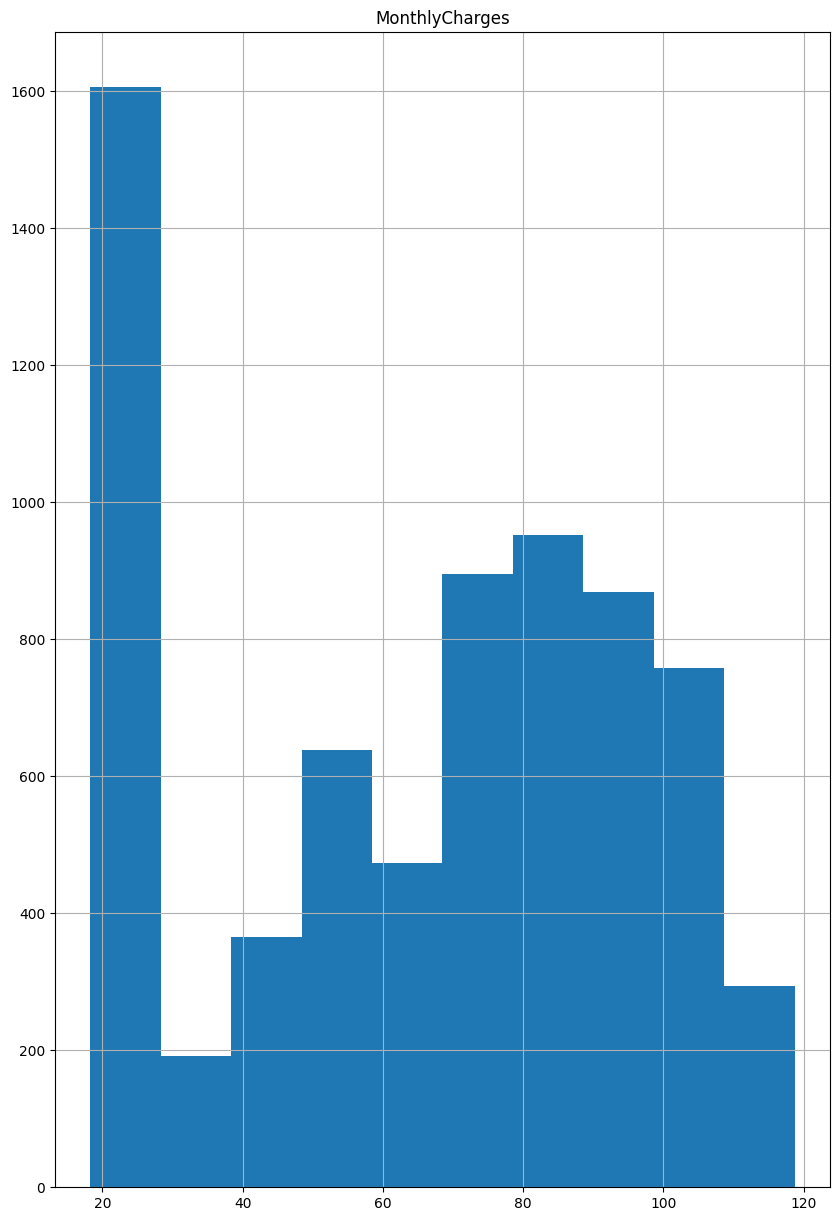

In [11]:
explore_data(contract_df)

**Комментарий:** 
1. В датафрейме contract_df нету явных пропусков
2. Большинство абонентов в месяц платят около 20 - 30 ед. валюты
3. Большинство абонентов не ушло от оператора
4. Столбец "PaperlessBilling" следует удалить, так как он не будет помогать моделям предсказывать целевой признак

Первые 5 строк набора данных:


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



Информация о наборе данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None


Статистические характеристики числовых столбцов:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,7590-VHVEG,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Число уникальных значений в каждом столбце:
Столбец 'customerID' содержит 7043 уникальных значений.

Столбец 'gender' содержит 2 уникальных значений.

Столбец 'SeniorCitizen' содержит 2 уникальных значений.

Столбец 'Partner' содержит 2 уникальных значений.

Столбец 'Dependents' содержит 2 уникальных значений.


Число значений по категориям в каждом столбце:
Столбец 'customerID':
customerID
7590-VHVEG    1
3791-LGQCY    1
6008-NAIXK    1
5956-YHHRX    1
5365-LLFYV    1
             ..
9796-MVYXX    1
2637-FKFSY    1
1552-AAGRX    1
4304-TSPVK    1
3186-AJIEK    1
Name: count, Length: 7043, dtype: int64

Столбец 'gender':
gender
Male      3555
Female    3488
Name: count, dtype: int64

Столбец 'Partner':
Partner
No     3641
Yes    3402
Name: count, dtype: int64

Столбец 'Dependents':
Dependents
No     4933
Yes    2110
Name: count, dtype: int64


Гистограммы всех числовых столбцов:


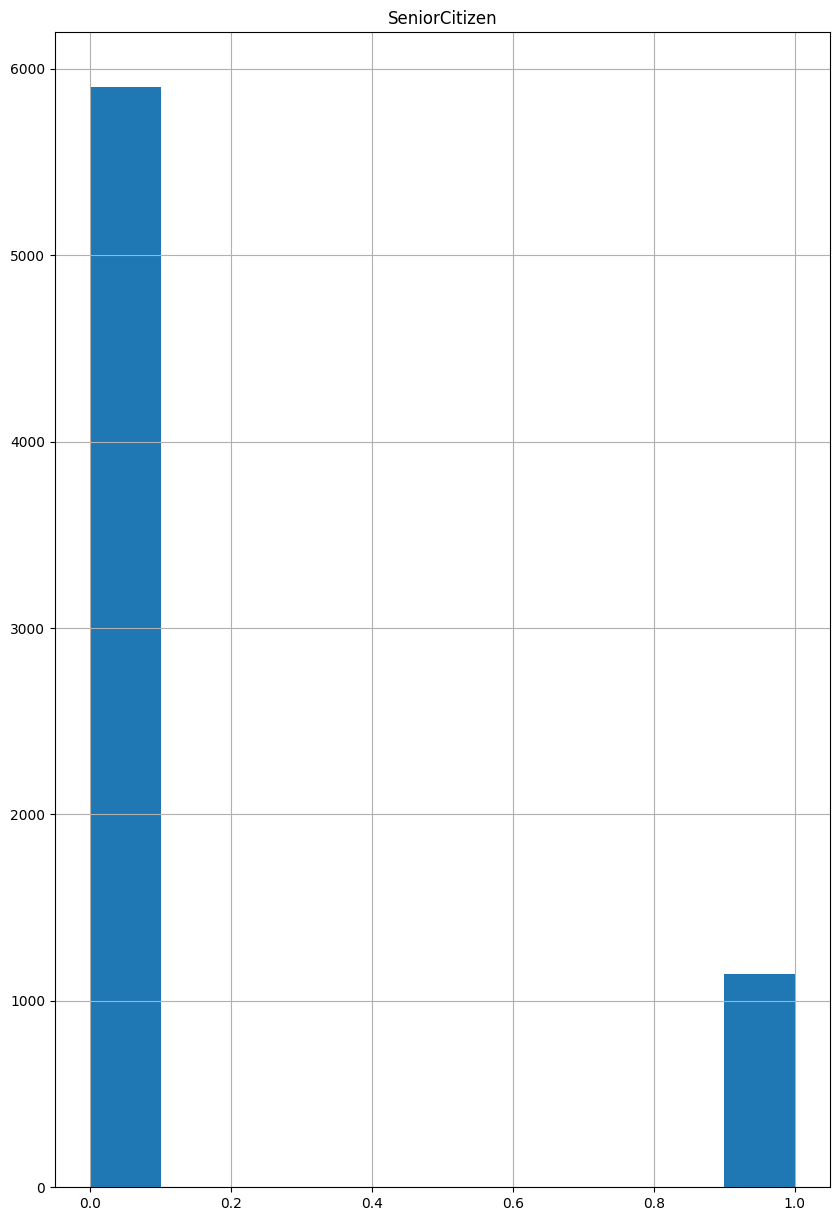

In [12]:
explore_data(personal_df)

**Комментарий:**
1. В датафрейме personal_df нету явных пропусков
2. Большинство абонентов - молодые люди
3. Большинство абонентов не являются иждивенцами
4. Столбец "gender" следует удалить, так как он не будет помогать моделям предсказывать целевой признак

In [13]:
explore_data(internet_df)

Первые 5 строк набора данных:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



Информация о наборе данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None


Статистические характеристики числовых столбцов:


,count,unique,top,freq
customerID,5517,5517,7590-VHVEG,1
InternetService,5517,2,Fiber optic,3096
OnlineSecurity,5517,2,No,3498
OnlineBackup,5517,2,No,3088
DeviceProtection,5517,2,No,3095
TechSupport,5517,2,No,3473
StreamingTV,5517,2,No,2810
StreamingMovies,5517,2,No,2785



Число уникальных значений в каждом столбце:
Столбец 'customerID' содержит 5517 уникальных значений.

Столбец 'InternetService' содержит 2 уникальных значений.

Столбец 'OnlineSecurity' содержит 2 уникальных значений.

Столбец 'OnlineBackup' содержит 2 уникальных значений.

Столбец 'DeviceProtection' содержит 2 уникальных значений.

Столбец 'TechSupport' содержит 2 уникальных значений.

Столбец 'StreamingTV' содержит 2 уникальных значений.

Столбец 'StreamingMovies' содержит 2 уникальных значений.


Число значений по категориям в каждом столбце:
Столбец 'customerID':
customerID
7590-VHVEG    1
5181-OABFK    1
9356-AXGMP    1
5176-OLSKT    1
7508-DQAKK    1
             ..
1104-FEJAM    1
2972-YDYUW    1
4238-JSSWH    1
0869-PAPRP    1
3186-AJIEK    1
Name: count, Length: 5517, dtype: int64

Столбец 'InternetService':
InternetService
Fiber optic    3096
DSL            2421
Name: count, dtype: int64

Столбец 'OnlineSecurity':
OnlineSecurity
No     3498
Yes    2019
Name: count, dtype: int

**Комментарий:**
1. В датафрейме personal_df нету явных пропусков
2. Большинство абонентов имеют подключение к интернету через оптоволоконный кабель
3. Большинству абонентов не интересны дополнительные услуги оператора

In [14]:
explore_data(phone_df)

Первые 5 строк набора данных:


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes



Информация о наборе данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None


Статистические характеристики числовых столбцов:


,count,unique,top,freq
customerID,6361,6361,5575-GNVDE,1
MultipleLines,6361,2,No,3390



Число уникальных значений в каждом столбце:
Столбец 'customerID' содержит 6361 уникальных значений.

Столбец 'MultipleLines' содержит 2 уникальных значений.


Число значений по категориям в каждом столбце:
Столбец 'customerID':
customerID
5575-GNVDE    1
0980-FEXWF    1
8082-GHXOP    1
3393-FMZPV    1
8701-DGLVH    1
             ..
8197-BFWVU    1
9154-QDGTH    1
8499-BRXTD    1
8552-OBVRU    1
3186-AJIEK    1
Name: count, Length: 6361, dtype: int64

Столбец 'MultipleLines':
MultipleLines
No     3390
Yes    2971
Name: count, dtype: int64

В данном df нету числовых столбцов


**Комментарий:**
1. В датафрейме phone_df нету явных пропусков
2. Большинство абонентов не имеют возможность ведения параллельных линий во время звонка

## Вывод по 1 части проекта

**Вывод:** На первом этапе проекта 
1. Выполнилась загрузка данных
2. Проведенно первичное исследование данных, где: 
    * Выяснились некоторые факты о абонентах оператора
    * Во всех датафреймах нету пропусков
    * Некоторые столбцы стоит удалить, так как они не помогут моделям лучше предсказывать, а только увеличат длительность их обучения и предсказания
    * Названия столбцов нужно привести к нижнему ("змеиному") регистру, так как:

         Единообразие и согласованность: Приведение названий столбцов к нижнему регистру позволяет обеспечить единообразие в структуре данных и согласованность в их написании. Все столбцы в нижнем регистре выглядят более однородно и легче воспринимаются.

         Удобство использования: Использование названий столбцов в нижнем регистре упрощает работу с данными, особенно при доступе к столбцам через атрибуты датафрейма. В случае, когда регистр букв может варьироваться, это может привести к нежелательным ошибкам при обращении к столбцам.

         Совместимость с различными системами и инструментами: Многие базы данных и инструменты для анализа данных регистронезависимы при обращении к названиям столбцов. Однако, некоторые системы или инструменты могут предпочитать или требовать названия столбцов в нижнем регистре. Поэтому, приведение к нижнему регистру может обеспечить лучшую совместимость и избежать возможных проблем.

## Дальнейший план работы

1) Планируется приступить к выполению 2 части проекта, а именно:
   * Предобработка данных (обработка дубликатов и аномалий, приведение данных к нужным типам, создание новых признаков и удаление ненужных) 
   * Объединение всех датафреймов в один
   * Разделение данных на тестовую и тренировочную выборки
   * Кодирование масштабирование (при необходимости)
   * Подбор лучшей модели на кросс-валидации
   * Проверка лучшей модели на тестовой выборке
   * Исследование признаков лучшей модели + матрица ошибок
2) После выполнения 2 части проекта планируется написание отчета

# Вторая часть

## Объединение всех датафреймов

In [15]:
df = contract_df.merge(personal_df, on='customerID', how='left')
df = df.merge(internet_df, on='customerID', how='left')
df = df.merge(phone_df, on='customerID', how='left')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


## Предобработка данных

###  Приведение названий столбцов к нижнему регистру

In [17]:
df = clean_columns(df)
df.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines'],
      dtype='object')

### Приведение столбцов к нужным типам и замена значений

In [18]:
df['begin_date'] = pd.to_datetime(df['begin_date'])
df['end_date'] = pd.to_datetime(df['end_date'], errors='coerce')
df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce')
df = df[df['begin_date'] <= pd.to_datetime('2020-02-01')] #Проверяем, нет ли в df ошибочных данных
df.shape

C:\Users\yarma\AppData\Local\Temp\ipykernel_2396\3000657312.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['end_date'] = pd.to_datetime(df['end_date'], errors='coerce')


(7043, 20)

In [19]:
df = df.replace({'yes': 1, 'Yes': 1, 'no': 0, 'No': 0, np.nan : 0})
df['internet_service'] = df['internet_service'].astype(str)# Чтобы OHE не ругался на смешанный тип данных
df.sample(5)

C:\Users\yarma\AppData\Local\Temp\ipykernel_2396\4026628159.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({'yes': 1, 'Yes': 1, 'no': 0, 'No': 0, np.nan : 0})


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
4131,2876-VBBBL,2019-12-01,0,Month-to-month,1,Mailed check,20.25,40.5,Female,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1165,6479-OAUSD,2018-01-01,2018-07-01 00:00:00,One year,0,Credit card (automatic),19.90,119.4,Male,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6465,8164-OCKUJ,2015-03-01,0,Two year,0,Mailed check,20.60,1215.4,Female,0,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6510,0572-ZJKLT,2016-04-01,0,Two year,0,Mailed check,99.65,4583.9,Female,0,1,1,Fiber optic,1.0,0.0,1.0,1.0,0.0,1.0,1.0
557,1154-HYWWO,2016-12-01,0,One year,0,Mailed check,70.60,2682.8,Male,0,0,0,DSL,1.0,1.0,0.0,1.0,1.0,0.0,0.0


In [20]:
df[df.columns[df.isin([0, 1]).all()]] = df[df.columns[df.isin([0, 1]).all()]].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   int32         
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int32         
 10  partner            7043 non-null   int32         
 11  dependents         7043 non-null   int32         
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   int32         
 14  online_b

### Создание нового признака

In [21]:
current_date = pd.to_datetime('2020-02-01')  # Дата для расчета, если end_date равно '0'
df['days_with_operator'] = df.apply(lambda row: (current_date - row['begin_date']).days
                                     if row['end_date'] == 0
                                     else (row['end_date'] - row['begin_date']).days, axis=1).astype(int)


df['days_with_operator'].sample(5)

1176    276
2246    123
5358    549
2892     31
967      92
Name: days_with_operator, dtype: int32

### Создание целевого признака

In [22]:
df['churn'] = df['end_date'].apply(lambda x: 1 if x != 0 else 0)
df.sample(5)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,days_with_operator,churn
6171,1658-XUHBX,2015-03-01,2017-02-01 00:00:00,Month-to-month,1,Credit card (automatic),88.75,2082.07,Female,1,1,1,Fiber optic,0,0,1,0,0,1,1,703,1
3521,2550-AEVRU,2015-05-01,0,One year,0,Electronic check,53.45,3198.98,Female,0,1,1,DSL,1,1,0,0,0,0,0,1737,0
1162,9359-UGBTK,2014-07-01,0,One year,1,Bank transfer (automatic),72.35,4847.45,Female,0,0,0,DSL,1,0,1,1,0,1,0,2041,0
7008,1980-KXVPM,2019-09-01,0,Month-to-month,1,Credit card (automatic),75.05,375.25,Female,1,0,0,Fiber optic,0,0,0,0,0,0,1,153,0
5150,7017-VFULY,2019-12-01,0,Month-to-month,0,Bank transfer (automatic),20.10,43.42,Female,0,1,0,0,0,0,0,0,0,0,0,62,0


### Удаление лишних столбцов

In [23]:
df = df.drop(columns=['paperless_billing', 'gender', 'customer_id', 'begin_date', 'end_date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   type                7043 non-null   object 
 1   payment_method      7043 non-null   object 
 2   monthly_charges     7043 non-null   float64
 3   total_charges       7043 non-null   float64
 4   senior_citizen      7043 non-null   int32  
 5   partner             7043 non-null   int32  
 6   dependents          7043 non-null   int32  
 7   internet_service    7043 non-null   object 
 8   online_security     7043 non-null   int32  
 9   online_backup       7043 non-null   int32  
 10  device_protection   7043 non-null   int32  
 11  tech_support        7043 non-null   int32  
 12  streaming_tv        7043 non-null   int32  
 13  streaming_movies    7043 non-null   int32  
 14  multiple_lines      7043 non-null   int32  
 15  days_with_operator  7043 non-null   int32  
 16  churn 

**Вывод:** В ходе предобработки данных
1. Несколько df были объеденены в 1 df
2. Названия всех столбцов приведены к змеиному регистру
3. Столбцы begin_date и end_date были приведы к типу datetime для дальнейшей работы с этими столбцами 
4. Все столбцы, содержащие yes/no заменены на 1/0, так как:
    * Легкость интерпретации: Многие алгоритмы машинного обучения, включая градиентный бустинг, работают лучше с числовыми данными. Замена "yes/no" на "1/0" делает данные числовыми и упрощает интерпретацию модели
    * Улучшение производительности: Некоторые алгоритмы машинного обучения могут эффективнее работать с числовыми данными, что может привести к улучшению производительности модели
    - А так же столбцы с 1/0 были переведены в тип int, так как он обрабатывается моделями машинного обучения быстрее и занимает меньше места в памяти по сравнению с типом данных object
5. Был создан новый признак days_with_operator, который указывает, сколько дней провел с оператором каждый абонент на 1 февраля 2020 года
6. Создан целевой признак churn, который показывает факт ухода абонентов
7. Произведено удаление лишних столбцов, которые не несут для моделей какой-либо важной информации для предсказания: paperless_billing, gender, customer_id, begin_date, end_date

## Разделение данных на выборки

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['churn']), df['churn'], test_size=0.25, random_state=250923)

**Вывод:** Данные разделены на тестовую и тренировочную выборки в соотношении 25%/75%

## Кодирование 

In [25]:
columns_to_encode = ['type', 'payment_method', 'internet_service']

encoder = OneHotEncoder(sparse=False)

# Кодируем признаки в тренировочной выборке
encoded_data_train = encoder.fit_transform(X_train[columns_to_encode])

# Создаем DataFrame с закодированными признаками для тренировочной выборки
encoded_df_train = pd.DataFrame(encoded_data_train, columns=encoder.get_feature_names(columns_to_encode), index=X_train.index)

# Обновляем тренировочную выборку
X_train = pd.concat([X_train, encoded_df_train], axis=1)
X_train = X_train.drop(columns=columns_to_encode)

# Кодируем признаки в тестовой выборке
encoded_data_test = encoder.transform(X_test[columns_to_encode])

# Создаем DataFrame с закодированными признаками для тестовой выборки
encoded_df_test = pd.DataFrame(encoded_data_test, columns=encoder.get_feature_names(columns_to_encode), index=X_test.index)

# Обновляем тестовую выборку
X_test = pd.concat([X_test, encoded_df_test], axis=1)
X_test = X_test.drop(columns=columns_to_encode)

**Вывод:**  Столбцы type, internet_service и payment_method были закодированы для дальнейшего обучения моделей

## Машинное обучение

In [26]:
def optimize_model(name, model, param_distributions, X_train, y_train):
    
    optuna = OptunaSearchCV(
    model, 
    param_distributions=param_distributions, 
    cv=5, 
    n_trials=100, 
    scoring='roc_auc', 
    n_jobs=-1,
    )
    
    optuna.fit(X_train, y_train)
    
    print(f'Лучшие параметры для {name}:', optuna.best_params_)
    print(f'Метрика на кросс-валидации для {name}:', optuna.best_score_)
    
    return optuna.best_params_

In [27]:
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(logging.WARNING)

### XGBClassifier

In [28]:
xgb_param_distributions = {
    'n_estimators': optuna.distributions.IntDistribution(50, 500),
    'max_depth': optuna.distributions.IntDistribution(3, 10),
    'learning_rate': optuna.distributions.FloatDistribution(0.01, 0.1),
    'min_child_weight': optuna.distributions.IntDistribution(1, 10),
    'gamma': optuna.distributions.IntDistribution(0, 1.0),
    'subsample': optuna.distributions.FloatDistribution(0.5, 1.0),
    'colsample_bytree': optuna.distributions.FloatDistribution(0.5, 1.0),
    'reg_alpha': optuna.distributions.IntDistribution(0, 1.0),
    'reg_lambda': optuna.distributions.IntDistribution(0, 1.0),
    'scale_pos_weight': optuna.distributions.IntDistribution(1, 10),
}

xgb_best_params = optimize_model('XGBClassifier',
    XGBClassifier(eval_metric='error', random_state=250923), xgb_param_distributions, X_train, y_train
)


Лучшие параметры для XGBClassifier: {'n_estimators': 458, 'max_depth': 4, 'learning_rate': 0.0762564876121307, 'min_child_weight': 2, 'gamma': 0, 'subsample': 0.905234326474519, 'colsample_bytree': 0.8876431518237631, 'reg_alpha': 1, 'reg_lambda': 0, 'scale_pos_weight': 4}
Метрика на кросс-валидации для XGBClassifier: 0.9006828259988519


### LGBMClassifier

In [29]:
lgbm_param_distributions = {
    'n_estimators': optuna.distributions.IntDistribution(50, 500),
    'max_depth': optuna.distributions.IntDistribution(3, 10),
    'learning_rate': optuna.distributions.FloatDistribution(0.01, 0.1),
    'num_leaves': optuna.distributions.IntDistribution(20, 50),
    'min_child_samples': optuna.distributions.IntDistribution(2, 20),
    'subsample': optuna.distributions.FloatDistribution(0.5, 1.0),
    'colsample_bytree': optuna.distributions.FloatDistribution(0.5, 1.0),
}
lgb_model = LGBMClassifier(eval_metric='error', random_state=250923)

lgbm_best_params = optimize_model('LGBMClassifier',
   lgb_model, lgbm_param_distributions, X_train, y_train
)

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 820, number of negative: 4462
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 728
[LightGBM] [Info] Number of data points in the train set: 5282, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.155244 -> initscore=-1.694048
[LightGBM] [Info] Start training from score -1.694048
Лучшие параметры для LGBMClassifier: {'n_estimators': 366, 'max_depth': 9, 'learning_rate': 0.09235501427975056, 'num_leaves': 24, 'min_child_samples': 7, 'subsample': 0.7228441712872525, 'colsample_bytree': 0.6017551091732136}
Метрика на кросс-валидации для LGBMClassifier: 0.9065167971899515


### CatBoostClassifier

In [30]:
catboost_param_distributions = {
    'iterations': optuna.distributions.IntDistribution(50, 500),
    'depth': optuna.distributions.IntDistribution(3, 10),
    'learning_rate': optuna.distributions.FloatDistribution(0.01, 0.1),
    'l2_leaf_reg': optuna.distributions.IntDistribution(1, 10),
    'subsample': optuna.distributions.FloatDistribution(0.5, 1.0),
    'colsample_bylevel': optuna.distributions.FloatDistribution(0.5, 1.0),
    'verbose': optuna.distributions.CategoricalDistribution([0])
}
catboost_model = CatBoostClassifier(random_state=250923)

catboost_best_params = optimize_model('CatBoostClassifier',
    catboost_model, catboost_param_distributions, X_train, y_train
)

Лучшие параметры для CatBoostClassifier: {'iterations': 487, 'depth': 4, 'learning_rate': 0.0887561413241534, 'l2_leaf_reg': 2, 'subsample': 0.5412912515907076, 'colsample_bylevel': 0.9999480013082004, 'verbose': 0}
Метрика на кросс-валидации для CatBoostClassifier: 0.9115143245023484


**Вывод:** По результатам кросс-валидации лучшие показатели у модели CatBoostClassifier

## Проверка качетсва лучшей модели на тестовой выборке

In [31]:
best_model = CatBoostClassifier(**catboost_best_params, random_state=250923)


best_model.fit(X_train, y_train)


predictions_test = best_model.predict_proba(X_test)[:, 1]


roc_auc = roc_auc_score(y_test, predictions_test)

print("ROC AUC на тестовой выборке:", roc_auc)

ROC AUC на тестовой выборке: 0.9224103106665384


**Вывод:** Модель подходит для заказчика

## Исследование важности признаков лучшей модели

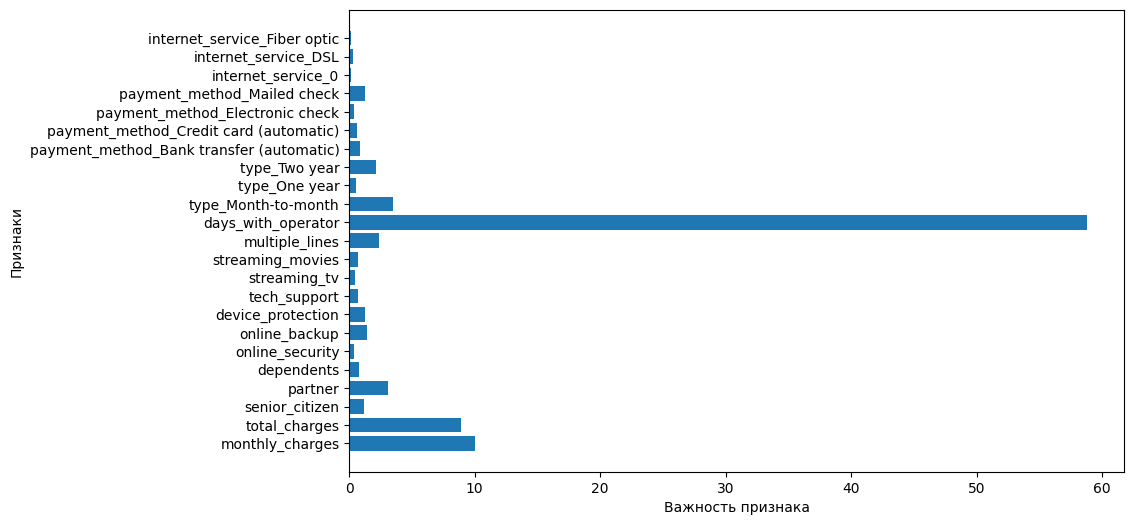

In [32]:
feature_importance = best_model.feature_importances_


plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, feature_importance)
plt.xlabel('Важность признака')
plt.ylabel('Признаки')
plt.show()

**Вывод:** Самые важные признаки для модели CatBoostClassifier - это days_with_operator, monthly_charges и monthly_charges

### Матрица ошибок

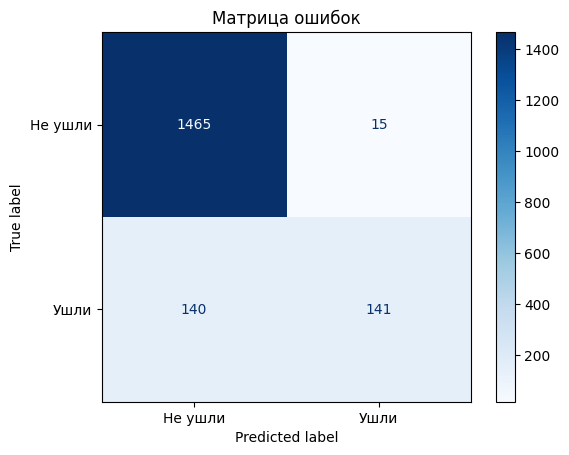

In [33]:
cm = confusion_matrix(y_test, best_model.predict(X_test))

plot_confusion_matrix(best_model, X_test, y_test, cmap=plt.cm.Blues, display_labels=['Не ушли', 'Ушли'])
plt.title('Матрица ошибок')
plt.show()

**Вывод:** Исходя из значений матрицы ошибок
* Чувствительность = TP / (TP + FN) = 1465 / (1465 + 140) ≈ 0.91. Это означает, что модель хорошо выявляет истинные положительные случаи и имеет высокую способность обнаруживать объекты положительного класса
* Специфичность = TN / (TN + FP) = 141 / (141 + 15) ≈ 0.9. Это означает, что модель также хорошо различает истинные отрицательные случаи и имеет способность избегать ложных срабатываний
* Точность = TP / (TP + FP) = 1465 / (1465 + 15) ≈ 0.99. Это говорит о том, что модель имеет высокую точность в предсказании положительных случаев
* F1-мера = 2 * (Точность * Чувствительность) / (Точность + Чувствительность) ≈ 0.958. Это говорит о хорошем балансе между точностью и чувствительностью
* AUC-ROC ≈ 0.93. AUC-ROC близка к 1, что указывает на хорошую способность модели разделять классы

## Вывод по 2 части проекта

* В ходе второй части проекта были проведены важные этапы предобработки данных:

    1.Объединение данных: Несколько DataFrame были объединены в один для более полного анализа

    2.Приведение к нижнему регистру: Названия всех столбцов были приведены к змеиному регистру для удобства работы с ними

    3.Преобразование дат: Столбцы begin_date и end_date были приведены к типу datetime для дальнейшего анализа и использования

    4.Бинарная классификация: Столбцы, содержащие "yes/no", были заменены на "1/0". Это упростило интерпретацию и улучшило производительность моделей машинного обучения

    5.Изменение типов данных: Столбцы с 1/0 были переведены в тип int, что способствует более быстрой обработке и экономии памяти

    6.Создание новых признаков: Был создан признак "days_with_operator", отражающий количество дней, проведенных с оператором, а также целевой признак "churn" для определения факта ухода абонентов

    7.Удаление лишних столбцов: Избыточные столбцы, которые не несли важной информации для предсказания, были удалены

* После этапа предобработки данных проведено обучение и оценка моделей машинного обучения. Лучшие показатели были получены с использованием модели CatBoostClassifier, что делает ее подходящей для заказчика ROC AUC на тестовой выборке составляет 0.92, что превышает порог заказчика в 0.85

* Анализ матрицы ошибок позволяет утверждать, что модель хорошо выявляет истинные положительные и отрицательные случаи. Метрики, такие как чувствительность, специфичность, точность и F1-мера, подтверждают качество классификации

* Важными признаками для модели CatBoostClassifier оказались "days_with_operator", "monthly_charges" и "monthly_charges"

* Результаты демонстрируют высокую эффективность модели CatBoostClassifier в задаче прогнозирования ухода абонентов, что делает ее рекомендуемым выбором для заказчика

# Отчет 

## План 

   * Загрузка данных и первый обзор их 
   * Предобработка данных (обработка дубликатов и аномалий, приведение данных к нужным типам, создание новых признаков и удаление ненужных) 
   * Объединение всех датафреймов в один
   * Разделение данных на тестовую и тренировочную выборки
   * Кодирование масштабирование (при необходимости)
   * Подбор лучшей модели на кросс-валидации
   * Проверка лучшей модели на тестовой выборке
   * Исследование признаков лучшей модели + матрица ошибок

Все пункты плана были выволненны, кроме масшабирования. Оно не потребовалось, так как использовались модели градиентого бустинга

## Трудности

1) Самая большая трудность была с индексами в df после кодирования. Кодировались только определенные столбцы, а потом объединялись с выборками. Модель писала, что индексация выходит за пределы. 
 * Решение: При склеивании закодированных столбцов с выбоками указал явно, что индексы должны совпадать с индексами выборок "index=X_train\test.index"
 2) Проблема с чрезмерными сообщениями в консоли от оптимизатора и моделей
 * Решение: Указание оптимизатору, что нужно выводить сообщения только степени "Ошибка"

## Ключевые шаги

1. Загрузка данных
2. Предобработка данных
3. Разделение данных на выборки
4. Подбор подходящей модели и ее гиперпараметров
5. Тестирование модели на тестовой выборке 

## Итоговая модель 

Модель: CatBoostClassifier

### Гиперпараметры

In [34]:
catboost_best_params

{'iterations': 487,
 'depth': 4,
 'learning_rate': 0.0887561413241534,
 'l2_leaf_reg': 2,
 'subsample': 0.5412912515907076,
 'colsample_bylevel': 0.9999480013082004,
 'verbose': 0}

### Качество

ROC AUC CatBoostClassifier на тестовой выборке: 0.92

### Список признаков 

In [35]:
X_train.columns

Index(['monthly_charges', 'total_charges', 'senior_citizen', 'partner',
       'dependents', 'online_security', 'online_backup', 'device_protection',
       'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines',
       'days_with_operator', 'type_Month-to-month', 'type_One year',
       'type_Two year', 'payment_method_Bank transfer (automatic)',
       'payment_method_Credit card (automatic)',
       'payment_method_Electronic check', 'payment_method_Mailed check',
       'internet_service_0', 'internet_service_DSL',
       'internet_service_Fiber optic'],
      dtype='object')

### Описание предобработки признаков

1) Большая часть признаков содержала выражения yes\no, поэтому эти выражения были заменены на 1\0 и столбцы переведены в тип int
2) Признаки type, payment_method и  internet_service были закодированы с помощью OHE 
3) Был создан новый признак days_with_operator, который показывал, сколько дней абонент сотрудничал с оператором
4) Был создан целевой признак churn, который отражал факт ухода абонента от оператора
5) Удалены лишние столбцы, которые не несли пользы для моделей: paperless_billing, gender, customer_id, begin_date, 'end_date

## Общий вывод 

В рамках данного проекта была выполнена обширная работа по анализу данных и созданию модели для прогнозирования ухода абонентов оператора связи. 

Часть 1: Первичное исследование данных

    Были загружены и проанализированы данные, что позволило выявить некоторые важные факты о поведении абонентов.

    Отмечается отсутствие пропусков во всех датафреймах, что положительно сказывается на качестве данных.

    Принято решение об удалении ненужных столбцов, что позволило улучшить производительность моделей машинного обучения.

    Приведение названий столбцов к нижнему регистру сделало данные более удобными для обработки и согласованными.

Часть 2: Предобработка данных и обучение моделей

    В данной части проекта проведено объединение данных из нескольких DataFrame для более полного анализа.

    Продолжено приведение названий столбцов к нижнему регистру, что обеспечивает единообразие и удобство работы с данными.

    Произведено преобразование дат в соответствующий формат datetime для дальнейшего анализа.

    Произведена бинарная классификация столбцов "yes/no", упрощая интерпретацию и повышая производительность моделей.

    Изменен тип данных в столбцах с 1/0 на int для улучшения обработки и экономии памяти.

    Созданы новые признаки, включая "days_with_operator" и целевой признак "churn".

    Удалены избыточные столбцы, не влияющие на качество предсказаний.

    Обучение моделей машинного обучения показало, что модель CatBoostClassifier демонстрирует наилучшие результаты с высокой ROC AUC (0.92) на тестовой выборке.

    Матрица ошибок и метрики классификации подтвердили высокое качество классификации модели.

    Выделены важные признаки, влияющие на прогнозирование ухода абонентов.

**Исходя из результатов проекта, рекомендуется использовать модель CatBoostClassifier для прогнозирования ухода абонентов, так как она демонстрирует высокую эффективность и соответствует требованиям заказчика.**